In [1]:
%run SPDEs.ipynb
%run Rule.ipynb
%run Model.ipynb
%run Noise.ipynb
%run full_visualization.ipynb
%run Algorithm_2.ipynb

In [31]:
a, b, s, t = -8, 8, 0, 10 # space-time boundaries

X_, T_ = np.linspace(a,b,1025), np.linspace(s,t,2001) # space-time grid for generating solutions
X, T = X_[::2], T_[::10] # space-time grid of observed points. O_X and O_T

k = 120 # Number of realizations

# Create realizations of initial conditions. 

IC1 = Noise().initial(40, X_, scaling = 1) # one cycle
IC2 = Noise().initial(40, X_, scaling = 2) # two cycles
IC4 = Noise().initial(40, X_, scaling = 4) # four cycles

IC = np.concatenate([IC1, IC2, IC4])

W = np.zeros((k, len(T_), len(X_))) # No forcing

Burgers_ = SPDE(BC = 'P', IC = IC, eps = 0.1).Burgers(W, T = T_, X = X_) # solve Burger's equations on the fine grid

Burgers = Burgers_[:,::10,::2] # Observed points of Burger's equations

513 201


In [4]:
R = Rule(kernel_deg = 2, noise_deg = -1.5, free_num = 2) # initialize rule. No multiplicative width and forcing. 

test = np.random.choice(np.arange(120), 20, replace = False) # choose test set

experiment = IML(Burgers, Rule = R, eps = 0.1, height = 3, deg = 2.5, T = T, X = X) # initialize experiment for algorithm 2
experiment.set_train_test(test = test) # initialize test set

experiment.set_trees() # extract trees

experiment.initialize_Predictions() 

experiment.training_models() # Create models for Step 2 of Algorithm 2

  0%|          | 0/20000 [00:00<?, ?it/s]

Creating Model


100%|██████████| 20000/20000 [08:15<00:00, 40.33it/s]


In [15]:
experiment.fit_training_model() # Linear fit for Step 2 of Algorithm 2

In [ ]:
experiment.learn_with_fitted() # Recurcive steps 3 & 4 of Algorithm 2

In [17]:
# Translate prediction to a dataframe for the visualization class

Prediction = experiment.to_df_list()

# Translate solution to a dataframe for the visualization class
Burgers_true = [pd.DataFrame(B, index = T, columns = X) for B in Burgers]

In [100]:
# Errors

show = summary(experiment.test)
er = show.errors(Burgers_true,Prediction)
print('')
av_er = show.errors(Burgers_true,Prediction, full = False, maxi = True)

Total relative error for all test cases: 0.0027524116347953176

Average error over all test cases: 0.0035956344583669463

Maximum relative error among test cases: 0.0158441960650443


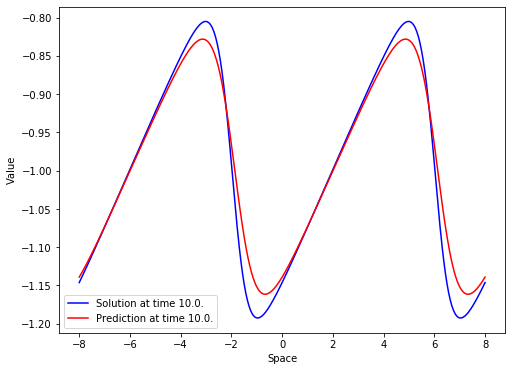

Error between solution and prediction at time 10.0 is : 0.022151514328101314.


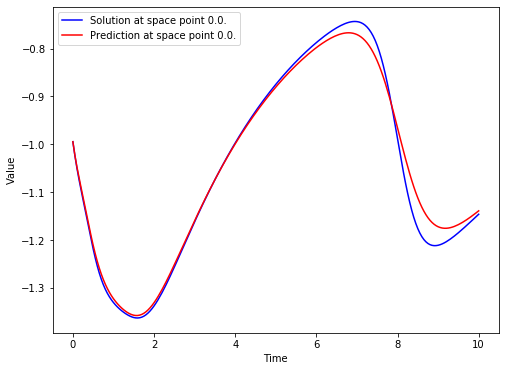

Error between solution and prediction at space point 0.0 is : 0.01973019664493831.


In [109]:
m, t, x = 1, 200, 256
show.time_comparison(m, t, Burgers_true, Prediction, title = False)
show.space_comparison(m, x, Burgers_true, Prediction, title = False)

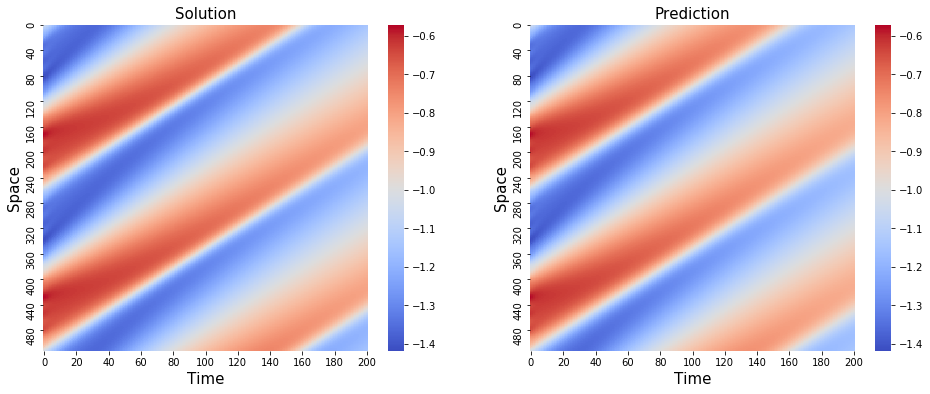

Error: 0.018860780442919323


In [107]:
show.full_comparison(m, Burgers_true, Prediction)

In [67]:
# Regression to determine viscosity from train cases

j = 0

u_t = np.array([(Burgers_true[i].iloc[j+1].values-Burgers_true[i].iloc[j]).values/(T[1]-T[0]) for i in range(120) if i not in test]).flatten()

dx = X[1]-X[0]

M = SPDE(BC = 'P').Parabolic_Matrix(len(X)-1, 1, dx, inverse = False)

u = np.array([Burgers_true[i].iloc[j].values for i in range(120) if i not in test])
u_xx = np.array([np.dot(M, U) for U in u]).flatten()

visc = lin_reg().fit(u_xx.reshape(-1, 1), u_t)

print("Viscocity raw:", visc.coef_)

Viscocity raw: [0.09055038]


In [69]:
# Algorithm 2 on the true data with learnt viscosity eps

experiment_v = IML(Burgers, Rule = R, eps = 0.0905, height = 3, deg = 2.5, T = T, X = X) # initialize experiment for algorithm 2
experiment_v.set_train_test(test = test) # initialize test set

experiment_v.trees = experiment.trees # extract trees

experiment_v.initialize_Predictions() 

experiment_v.training_models() # Create models for Step 2 of Algorithm 2

  0%|          | 0/20000 [00:00<?, ?it/s]

Creating Model


100%|██████████| 20000/20000 [09:12<00:00, 36.23it/s]


In [ ]:
experiment_v.fit_training_model() # Linear fit for Step 2 of Algorithm 2
experiment_v.learn_with_fitted() # Recurcive steps 3 & 4 of Algorithm 2

In [71]:
Prediction_v = experiment_v.to_df_list()

er_v = show.errors(Burgers_true,Prediction_v)
print('')
av_er_v = show.errors(Burgers_true,Prediction_v, full = False, maxi = True)

Total relative error for all test cases: 0.018671086964024305

Average error over all test cases: 0.03100327707291072

Maximum relative error among test cases: 0.08635671168250332


In [ ]:
# Euler Algorithm. Functions and implemintaton

def Euler_training(Solution, T, X, train, num):
        
    dt, dx = T[1]-T[0], X[1]-X[0]

    IC = np.array([Solution[u,i,:] for u in train for i in range(len(T)-1)])
    IC_x = np.array([SPDE().discrete_diff(ic, N = len(X), flatten=True, higher = False)/dx for ic in IC])
    Non_lin1 = IC*IC_x

    Delta_IC = np.array([np.dot(SPDE(BC = "P").Parabolic_Matrix(len(X)-1, 1, dx, inverse = False), ic) for ic in IC])

    Model = []
    for i, ic in enumerate(IC):
        M = {}
        k = 0
        for j in range(0-num,0+num+1):
            M[(k,1)] = np.array([IC[i], np.roll(IC[i], j)])
            M[(k,2)] = np.array([Non_lin1[i], np.roll(Non_lin1[i], j)])
            M[(k,3)] = np.array([Delta_IC[i], np.roll(Delta_IC[i], j)])
            k+=1
        Model.append(M)

    return Model
    
def Euler(start, Solution, Prediction, T, X, test, train, num, eps, higher = False):
    
    l, dx = len(test) + len(train), X[1]-X[0]
    IC = np.zeros((l, len(X)))
    if train != []:
        IC[train] = np.array([Solution[t, start, :] for t in train])
        IC[test] = experiment.cut_off(Prediction[start].T)
    else:
        IC = experiment.cut_off(Prediction[start].T)
    
    IC_x = np.array([SPDE().discrete_diff(IC[i], N = len(X), flatten=True, higher = False)/dx for i in range(l)])
    
    Non_lin1 = IC*IC_x
    
    Delta_IC = np.array([np.dot(SPDE(BC = "P").Parabolic_Matrix(len(X)-1, eps, dx, inverse = False), IC[i]) for i in range(l)])
    
    Model = []
    for i in tqdm(range(l)):
        M = {}
        k = 0
        for j in range(0-num,0+num+1):
            M[(k,1)] = np.array([IC[i], np.roll(IC[i], j)])
            M[(k,2)] = np.array([Non_lin1[i], np.roll(Non_lin1[i], j)])
            M[(k,3)] = np.array([Delta_IC[i], np.roll(Delta_IC[i], j)])
            k+=1
        Model.append(M)
            
    return Model

num = 0
dummy_interval = [1,2,3]

experiment_e = IML(Burgers, Rule = R, eps = 0.1, height = 3, deg = 2.5, X = X, T = T)
experiment_e.set_train_test(test = test)
experiment_e.trees = [(k,i) for k in range(2*num+1) for i in dummy_interval]
experiment_e.initialize_Predictions()

experiment_e.M_train = Euler_training(Burgers, T, X, experiment_e.train, num)

experiment_e.fit_training_model()



for i in range(0,15):
    experiment_e.M_test.append(Euler(i*experiment_e.step, experiment_e.Sol, experiment_e.Pred,
                                  experiment_e.T, experiment_e.X, experiment_e.test, [], num, 1))
    
    experiment_e.predict_with_fitted(i, experiment_e.M_test[-1], experiment_e.Pred, experiment_e.T, experiment_e.X,
                                     experiment_e.trees, experiment_e.test, experiment_e.train)

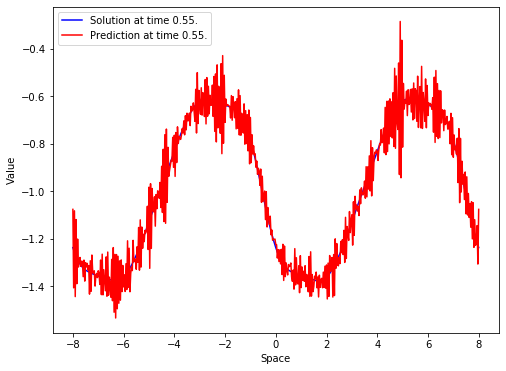

Error between solution and prediction at time 0.55 is : 0.07500455974399559.


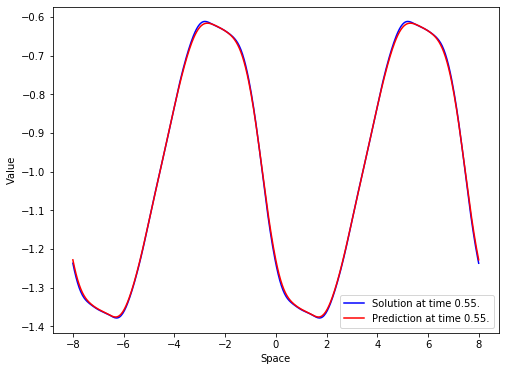

Error between solution and prediction at time 0.55 is : 0.004085951312805584.


In [108]:
# Comparison of predictions for Euler's algorithm and Algorithm 2

Prediction_e = experiment_e.to_df_list()

k, t = 1, 11
show.time_comparison(k, t, Burgers_true, Prediction_e, title = False)
show.time_comparison(k, t, Burgers_true, Prediction, title = False)

In [62]:
# PDE-FIND to learn coefficients of equation

dt, dx = T[1]-T[0], X[1]-X[0]
u = np.array([Burgers_true[i] for i in range(len(Burgers_true)) if i not in test])
# get viscosity and non linear coeficient of the Burgers equation
eps, lambd = PDE_FIND_Burgers(u, dt, dx, diff='finite_diff') 

print("Coefficients of equation obtained from PDE-FIND regression: Viscocity coef: {}, Non-lin coef: {}.".format(eps, lambd))

Coefficients of equation obtained from regression: Viscocity coef: 0.12713315329321892, Non-lin coef: -0.9594639712492525.


In [58]:
IC_ = IC[:,::2]

W_ = np.zeros((120, len(T_), len(X)))

Burgers_find = SPDE(BC = 'P', IC = IC_, eps = eps).Burgers(W_, lambd = lambd, T = T_, X = X)

Burgers_find = [pd.DataFrame(Burgers_find[i, ::10, :], index = T, columns = X) for i in test]


100%|██████████| 2000/2000 [00:04<00:00, 466.75it/s]


In [59]:
er_find = show.errors(Burgers_true,Burgers_find)
print('')
av_er_find = show.errors(Burgers_true,Burgers_find, full = False, maxi = True)

Total relative error for all test cases: 0.02734177451353686

Average error over all test cases: 0.03516041481111914

Maximum relative error among test cases: 0.07384874193117753
